# Pre-runtime Checks

## Checking what Type of GPU is Allocated to the Runtime

In [1]:
!nvidia-smi

Fri Apr 28 03:39:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8     4W /  50W |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

It's a good thing to note that if you're not happy with the GPU allocated to your runtime, you can reset the Colab runtime to try your luck with a better GPU.

# Import Libraries

## Install Required Libraries

In [2]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

## Import the Rest

In [3]:
import json
import pandas as pd
import numpy as np

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt
from matplotlib import rc

from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from termcolor import colored

import textwrap

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)

from tqdm.auto import tqdm 

/home/volt/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-04-28 03:39:24.049110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 03:39:25.361273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-28 03:39:25.361790: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; 

## Configure Plotting Libraries

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 16, 10

## Set a Global Seed Value

This ensures that everything in this notebook is reproducable.

In [5]:
pl.seed_everything(42)

Global seed set to 42


42

# Import the Dataset
Using [this Kaggle dataset](https://www.kaggle.com/datasets/sunnysai12345/news-summary) on _News Summaries_ to train our T5 model.

In [6]:
# !gdown --id 1NvrlwoYfPSj92igbh-7XIELRsXxBdVKU

In [7]:
df = pd.read_csv('../assets/data/news_summary.csv', encoding='latin-1')
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


## Get the Data to our Specifications

In [8]:
# Get only the columns that are needed.
df = df[['text', 'ctext']]

# Replace the column names.
df.columns = ['summary', 'text']

# Drop rows that don't have a value.
df = df.dropna()

df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [9]:
df.shape

(4396, 2)

# Apply Train-test Split

Here we split the dataset into training and testing dataframes.

In [10]:
train_df, test_df = train_test_split(df, test_size=0.1)

In [11]:
print(f"Shape of the Train Set: {train_df.shape}\nShape of the Test Set: {test_df.shape}")

Shape of the Train Set: (3956, 2)
Shape of the Test Set: (440, 2)


# Create a Pytorch Dataset using a Class

In [12]:
class NewsSummaryDataset(Dataset):
    def __init__(self, 
        data: pd.DataFrame, 
        tokenizer: T5Tokenizer, 
        text_max_token_len: int=512, 
        summary_max_token_len: int=128
    ):
        """
        A dataset that represents news articles and their respective summaries.

        Args:
        - data (pd.DataFrame): The data that contains the news articles and their summaries.
        - tokenizer (transformers.tokenization_*) : The tokenizer used to tokenize the text and summary.
        - text_max_token_len (int, optional): The maximum length of the text in terms of tokens. Defaults to 512.
        - summary_max_token_len (int, optional): The maximum length of the summary in terms of tokens. Defaults to 128.
        """
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
        
    def __len__(self):
        """
        Returns:
        - The number of samples in the dataset.
        """
        return len(self.data)
    
    def __getitem__(self, index):
        """
        Get a sample from the dataset.

        Args:
        - index (int): The index of the sample to get.

        Returns:
        - A dictionary that contains the following:
            - text (str): The original text of the news article.
            - summary (str): The summary of the news article.
            - text_input_ids (torch.Tensor): The input IDs of the text after tokenization.
            - text_attention_mask (torch.Tensor): The attention mask of the text after tokenization.
            - labels (torch.Tensor): The input IDs of the summary after tokenization.
            - labels_attention_mask (torch.Tensor): The attention mask of the summary after tokenization.
        """
        data_row = self.data.iloc[index]
        text = data_row["text"]

        # Encode the text.
        text_encoding = self.tokenizer(
            text, 
            max_length=self.text_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        # Encode the summary.
        summary_encoding = self.tokenizer(
            data_row["summary"], 
            max_length=self.summary_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        # Modify the labels so that the model knows which tokens to predict.
        labels = summary_encoding['input_ids']
        labels[labels == 0] = -100
        
        # Return a dictionary.
        return {
            'text': text,
            'summary': data_row['summary'],
            'text_input_ids': text_encoding['input_ids'].flatten(),
            'text_attention_mask': text_encoding['attention_mask'].flatten(),
            'labels': labels.flatten(),
            'labels_attention_mask': summary_encoding["attention_mask"].flatten()
        }

# Create Data Module for Pytorch Lightning

In [13]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df,
        test_df,
        tokenizer,
        batch_size=8,
        text_max_token_len=512,
        summary_max_token_len=128
    ):
        """
        Initializes the NewsSummaryDataModule.
        
        Args:
        - train_df (pandas.DataFrame): the training dataset
        - test_df (pandas.DataFrame): the testing dataset
        - tokenizer (transformers.PreTrainedTokenizer): the tokenizer to be used
        - batch_size (int): the batch size
        - text_max_token_len (int): the maximum number of tokens for the text
        - summary_max_token_len (int): the maximum number of tokens for the summary
        """
        super().__init__()
        
        self.train_df = train_df
        self.test_df = test_df
        
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
    
    def setup(self, stage=None):
        """
        Sets up the dataset.
        """
        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)
        
        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)
    
    def train_dataloader(self):
        """
        Returns the DataLoader for the training set.
        """
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )
    
    def test_dataloader(self):
        """
        Returns the DataLoader for the testing set.
        """
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )
    
    def val_dataloader(self):
        """
        Returns the DataLoader for the validation set, which is the same as the testing set.
        """
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

# Load the Pre-trained Model

In [14]:
MODEL_NAME = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

/home/volt/.local/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


# Working with Tokens

## Get the Token Counts for the Text and Summary

This is just to check the distribution of the tokens. It is understandable that the length of these is larger than what the model is allowed to take.

In [15]:
text_token_counts = [len(tokenizer.encode(row["text"])) for _, row in train_df.iterrows()]

summary_token_counts = [len(tokenizer.encode(row["summary"])) for _, row in train_df.iterrows()]

Token indices sequence length is longer than the specified maximum sequence length for this model (689 > 512). Running this sequence through the model will result in indexing errors


## Plot the Distribution of the Tokens

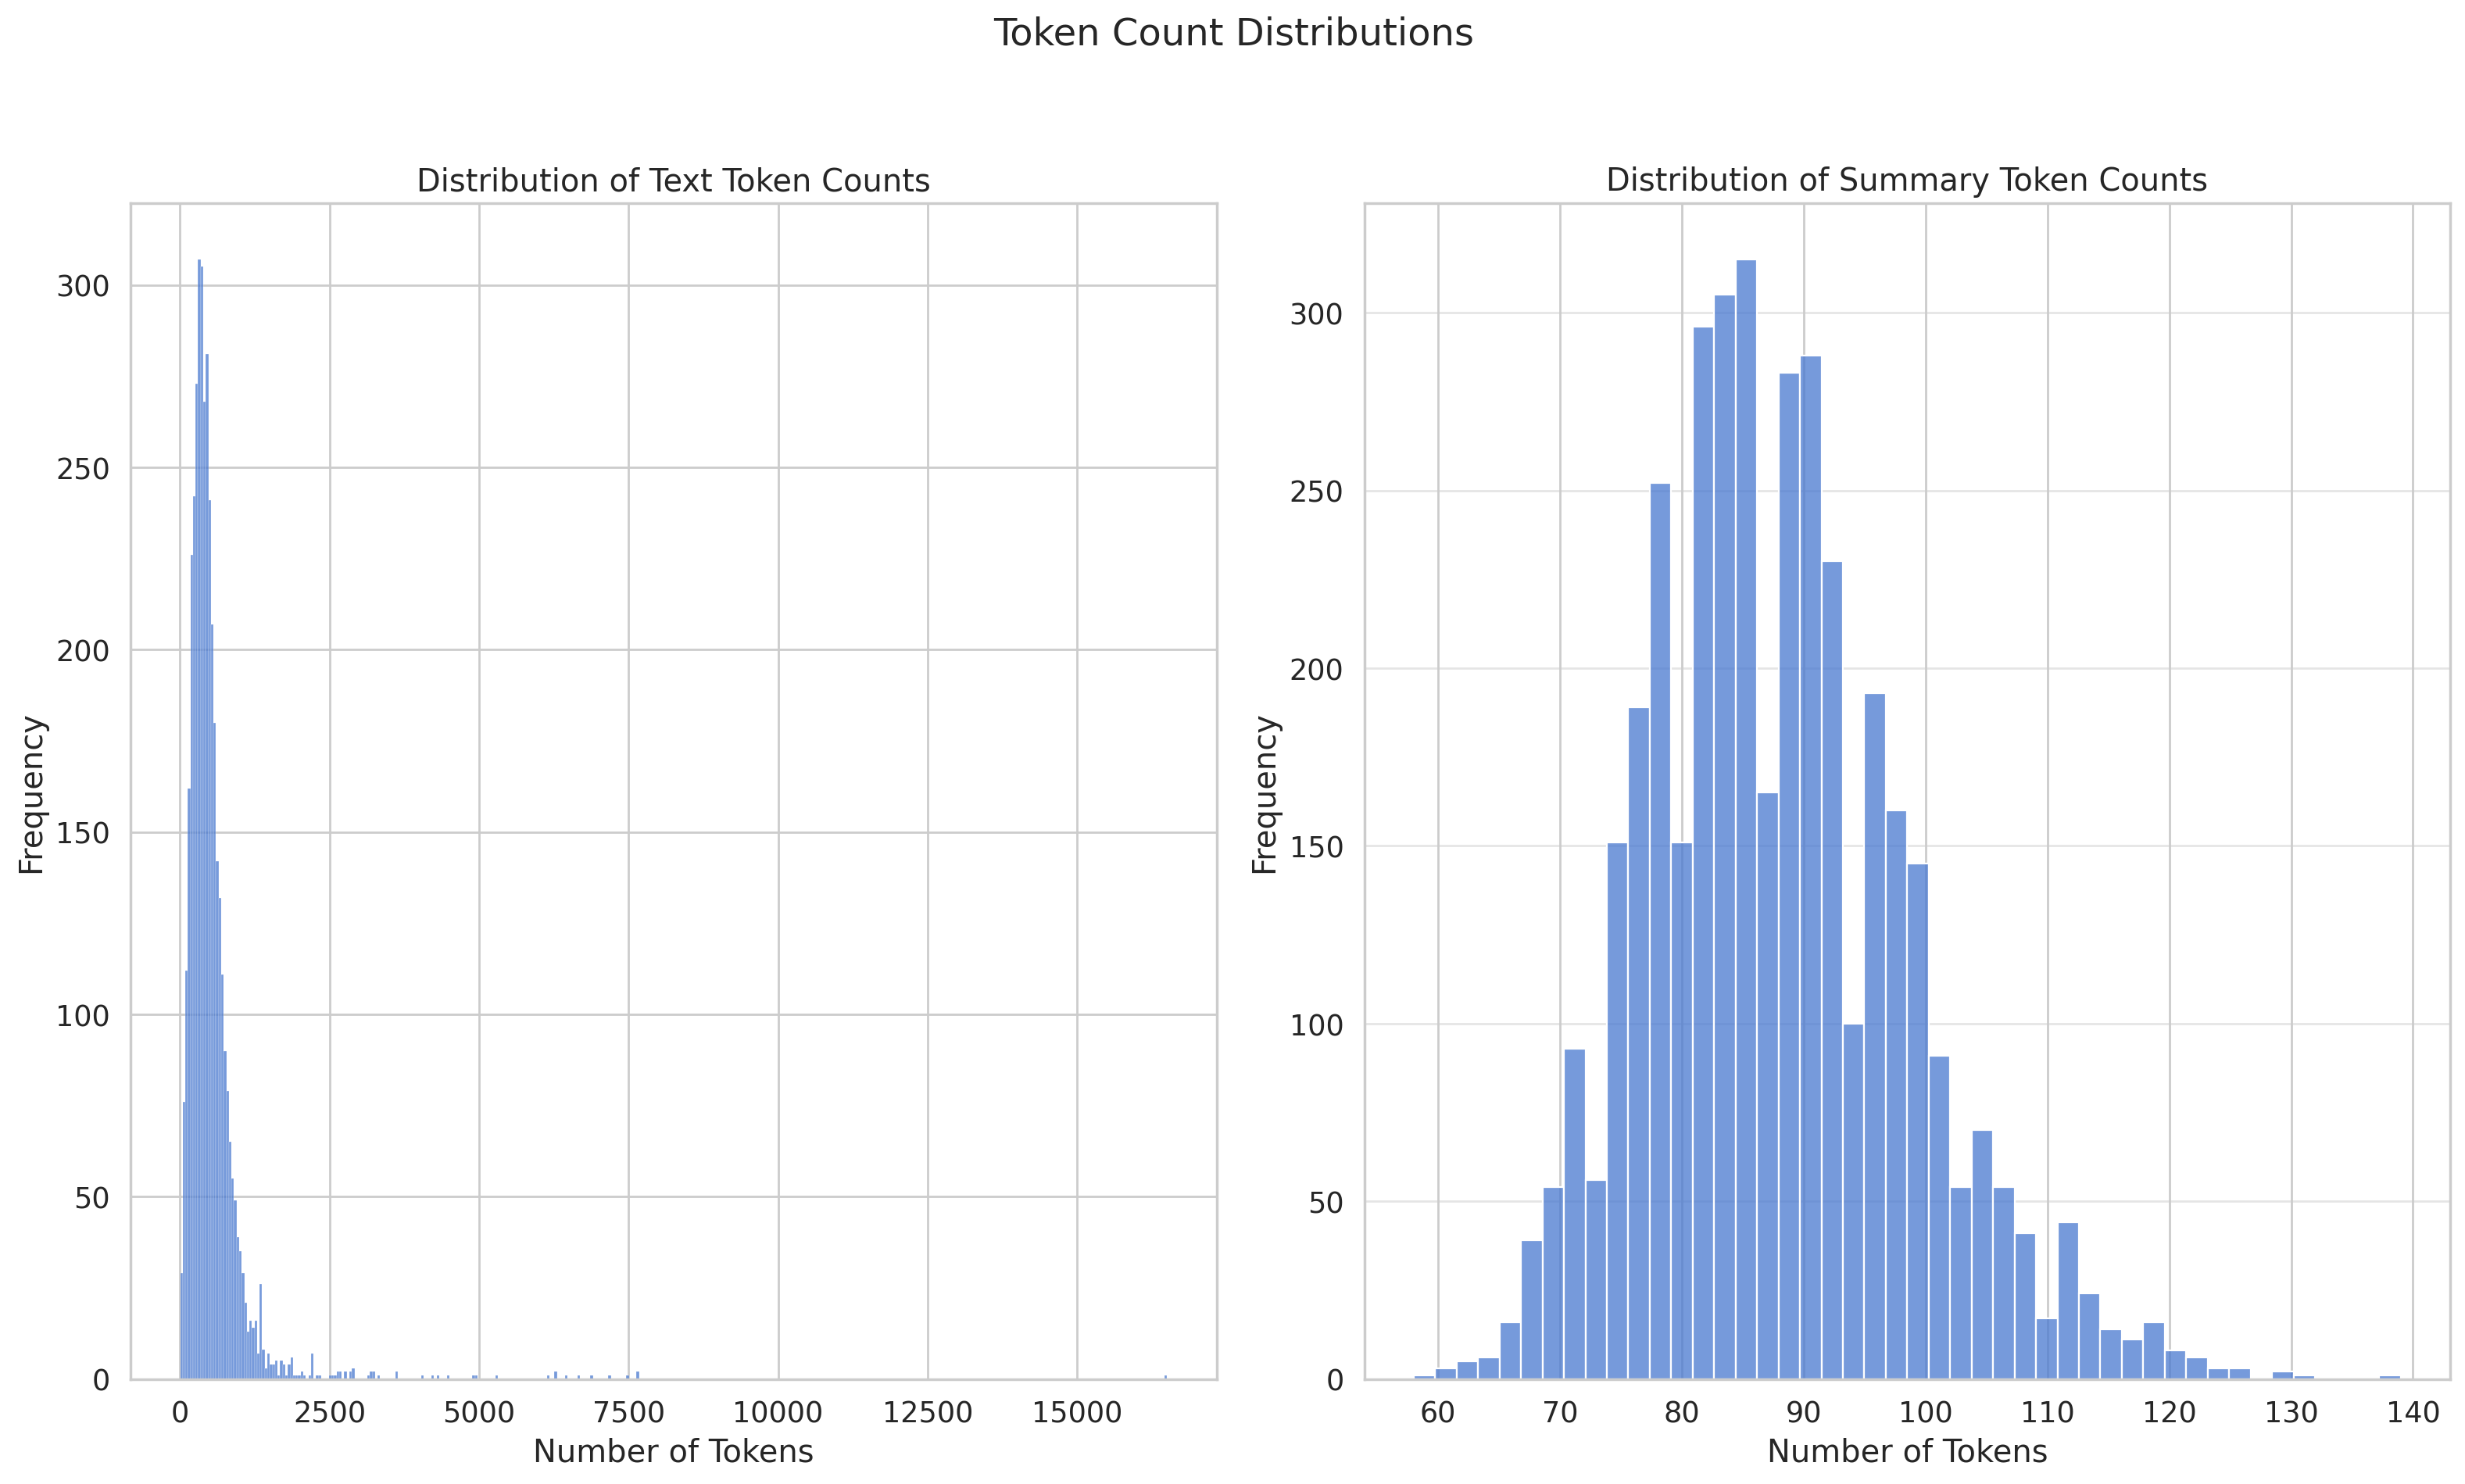

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(text_token_counts, ax=ax1)
ax1.set_title("Distribution of Text Token Counts")
ax1.set_xlabel("Number of Tokens")
ax1.set_ylabel("Frequency")
# ax1.grid(axis='y', alpha=0.5)

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title("Distribution of Summary Token Counts")
ax2.set_xlabel("Number of Tokens")
ax2.set_ylabel("Frequency")
ax2.grid(axis='y', alpha=0.5)

plt.suptitle("Token Count Distributions")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

From what we can tell from these distributions, the largest number of tokens lie in the 1200 - 1500 range. As for the summaries, the distribution fits close to 100% of samples within 140 tokens meaning that the summaries themselves are small, consise and are without any loss of information. 

# Define the Model

## Define the Hyperparameters

In [17]:
N_EPOCHS = 2
BATCH_SIZE = 4

data_module = NewsSummaryDataModule(
    train_df, 
    test_df,
    tokenizer,
    batch_size=BATCH_SIZE
)

## Construct the Model

In [18]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # Create an instance of the pre-trained T5 model
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)

    # Overwrite the forward() method
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        # Apply the model to the input IDs
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def shared_step(self, batch, batch_idx, stage):
        input_ids = batch['text_input_ids']
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, _ = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log(f"{stage}_loss", loss, prog_bar=True, logger=True)
        return loss

    # Step methods required by Pytorch Lightning
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'val')

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx, 'test')

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)


## Create an Instance of our Model

In [19]:
model = NewsSummaryModel()

In [20]:
%load_ext tensorboard
%tensorboard --logdir ./assets/logs

In [21]:
callbacks = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode='min'
)

logger = TensorBoardLogger("../assets/", name="logs")

trainer = pl.Trainer(
    logger=logger,
    callbacks=callbacks,
    max_epochs=N_EPOCHS
    # gpus=1,
    # progress_bar_refresh_rate=30
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Fit the Data to the Model and Start Training

In [22]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/volt/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/volt/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/home/volt/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 3.81 GiB total capacity; 3.50 GiB already allocated; 26.88 MiB free; 3.61 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Freeze the Best Performing Model from the Last Epoch

In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

# Set the Model and the Data to be on the Same Device

We move the model to the CPU after it's been trained on the GPU.

In [ ]:
# Set the device to a GPU if available, otherwise use the CPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = 'cpu'

# Move the model to the device
trained_model.to(device)

# Move the data to the device
# tensorTestDf = torch.tensor(test_df.values)
# tensorTestDf = tensorTestDf.to(device)

# Save the Model's Weights

In [ ]:
torch.save(trained_model.state_dict(), "fine_tuned_weights.pth")

# Performing Summarization

## Define Function to Summarize

In [ ]:
def summarize(text):
    text_encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Probably perform hyperparameter optimisation here.
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        
        # Turn this to False for a much cleaner output every time.
        early_stopping=True
    )

    # Predictions returned are nothing but an array of words.
    predictions = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]

    return "".join(predictions)

## Perform Summarization of a Random Sample

In [ ]:
sampleData = test_df.iloc[0]

In [ ]:
text = sampleData['text']
modelSummary = summarize(text)

## Compare Text to Model Summary 

### Text Data

In [ ]:
text

### Summary from Data

In [ ]:
sampleData['summary']

### Model Summary

In [ ]:
modelSummary